# <center><b>Natural Language Processing with Disaster Tweets</b></center>

# INTRODUCTION
Tweets are short social networking posts broadcasted over the Twitter platform (Wikipedia contributors, 2024). In 2023 the company was purchased by Elon Musk and is now known as X (Wikipedia contributors, 2024). Early detection of disaster events can aid first responders and hasten response time. Huang et al. (2022) has proposed the use of social media posts to help rapidly identify emergency events. The aim of this work is to use natural language processing (NLP) to analyze tweets and predict if they are describing a real disaster

## Reference
Wikipedia contributors. (2024, August 3). Twitter. Wikipedia. https://en.wikipedia.org/wiki/Twitter

Huang, L., Shi, P., Zhu, H., & Chen, T. (2022). Early detection of emergency events from social media: a new text clustering approach. Natural Hazards, 111(1), 851–875. https://doi.org/10.1007/s11069-021-05081-1


### Data
Addison Howard, devrishi, Phil Culliton, Yufeng Guo. (2019). Natural Language Processing with Disaster Tweets. Kaggle. https://kaggle.com/competitions/nlp-getting-started

# LIBRAIRIES

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import string
from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense, Masking, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import Precision, Recall

# IMPORT AND INSPECT DATA 
There are 7613 tweets in the training data set and 3263 in the test data set. The training data set includes five columns, id which is a unique identifier for each entry, keyword from the tweet, location that the tweet was sent from, text of the tweet and target indicating weather a tweet is about a real disaster (1) or not (0). The test data has the same features minus the target column. There are NaN entries in the location and feature columns in both data sets, and there are no blank entries. 

In [3]:
# Input data files are available in the read-only "../input/" directory
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename)) 


/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [4]:
train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

print(train.head())
print(test.head())

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
train.describe(include=object)

,keyword,location,text
count,7552,5080,7613
unique,221,3341,7503
top,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...
freq,45,104,10


In [6]:
print('The dimensions of the training data are:', train.shape)
print('The dimentions of the testing data are:',test.shape)

The dimensions of the training data are: (7613, 5)
The dimentions of the testing data are: (3263, 4)


### NaN Entries

In [7]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [8]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

### Blank Entries

In [9]:
(train == '').sum()

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

In [10]:
(test == '').sum()

id          0
keyword     0
location    0
text        0
dtype: int64

# BASIC DATA CLEANING AND EXPLORATORATION
The features keyword and location have been dropped. Although these could provide useful information for some applications, the goal here is to build a model which predicts disasters based on text and these features are not necessary for this. Looking at the distribution of the target variable approximately 57% of the tweets are not related to a real disaster and approximately 43% of the tweets are flagged as being about a real disaster. The longest tweet in both datasets is 31 words and the length of tweets in both data sets are normally distributed. 

In [11]:
train.drop(columns=['keyword','location'],inplace=True)
test.drop(columns=['keyword','location'],inplace=True)

print(train.head())
print(test.head())

   id                                               text  target
0   1  Our Deeds are the Reason of this #earthquake M...       1
1   4             Forest fire near La Ronge Sask. Canada       1
2   5  All residents asked to 'shelter in place' are ...       1
3   6  13,000 people receive #wildfires evacuation or...       1
4   7  Just got sent this photo from Ruby #Alaska as ...       1
   id                                               text
0   0                 Just happened a terrible car crash
1   2  Heard about #earthquake is different cities, s...
2   3  there is a forest fire at spot pond, geese are...
3   9           Apocalypse lighting. #Spokane #wildfires
4  11      Typhoon Soudelor kills 28 in China and Taiwan


In [12]:
print('The dimensions of the training data are:', train.shape)
print('The dimentions of the testing data are:',test.shape)

The dimensions of the training data are: (7613, 3)
The dimentions of the testing data are: (3263, 2)


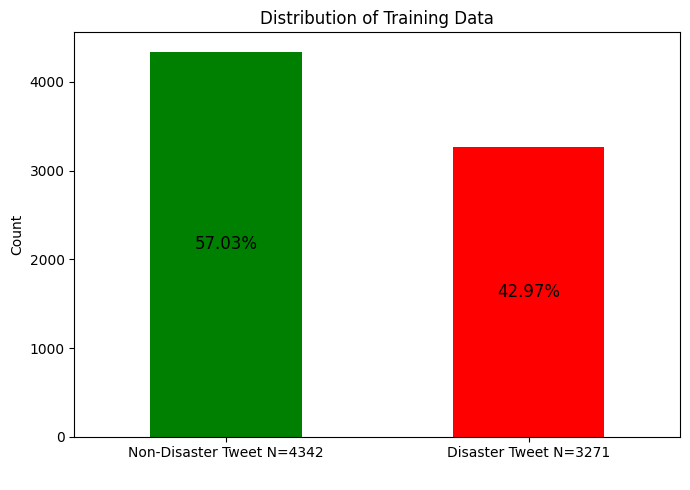

In [13]:
# Get counts of each class
label_counts = train['target'].value_counts()

# Create bar plot
plt.figure(figsize=(7, 5))
ax = label_counts.sort_index().plot(kind='bar', color=['green', 'red'])

plt.xticks([0, 1], labels=[f"Non-Disaster Tweet N={label_counts[0]}", f"Disaster Tweet N={label_counts[1]}"], rotation=0)

for i, count in enumerate(label_counts):
    percentage = count / label_counts.sum() * 100
    # Calculate bar height
    bar_height = count
    # Add percentages
    ax.text(i, bar_height / 2, f'{percentage:.2f}%', ha='center', va='center', fontsize=12)

plt.title(f'Distribution of Training Data')
plt.ylabel('Count')
plt.xlabel(" ")
plt.tight_layout()
plt.show()

In [14]:
# Calculate the length of each tweet 
train['text_length'] = train['text'].apply(lambda x: len(x.split()))
test['text_length'] = test['text'].apply(lambda x: len(x.split()))

# Find the length of the longest tweets
max_train_length = train['text_length'].max()
print(f"The longest tweet in the training set is {max_train_length} words long.")

max_test_length = test['text_length'].max()
print(f"The longest tweet in the test set is {max_test_length} words long.")

The longest tweet in the training set is 31 words long.
The longest tweet in the test set is 31 words long.


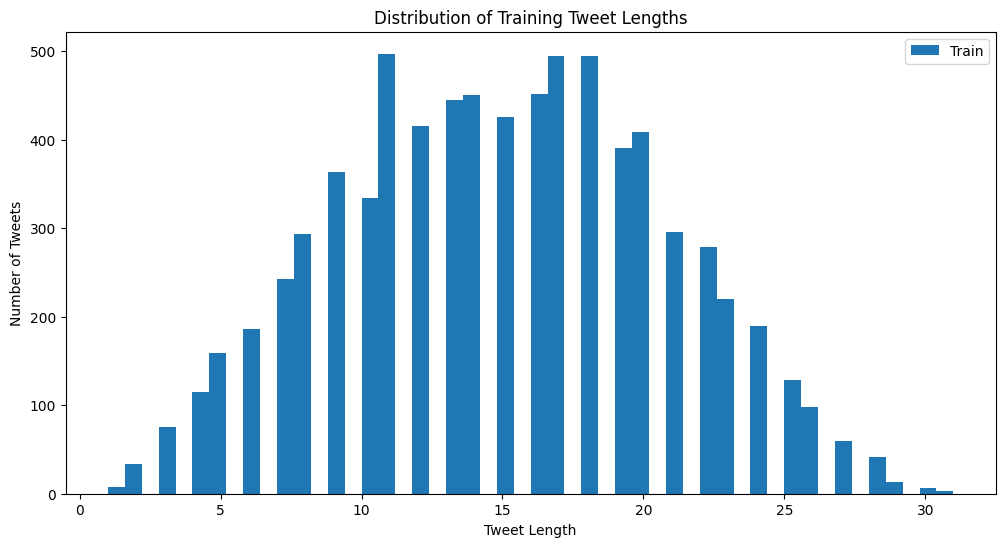

In [15]:
# Distribution of tweet lengths in the training set
plt.figure(figsize=(12, 6))
plt.hist(train['text_length'], bins=50, label='Train')
plt.xlabel('Tweet Length')
plt.ylabel('Number of Tweets')
plt.title('Distribution of Training Tweet Lengths')
plt.legend(loc='upper right')
plt.show()

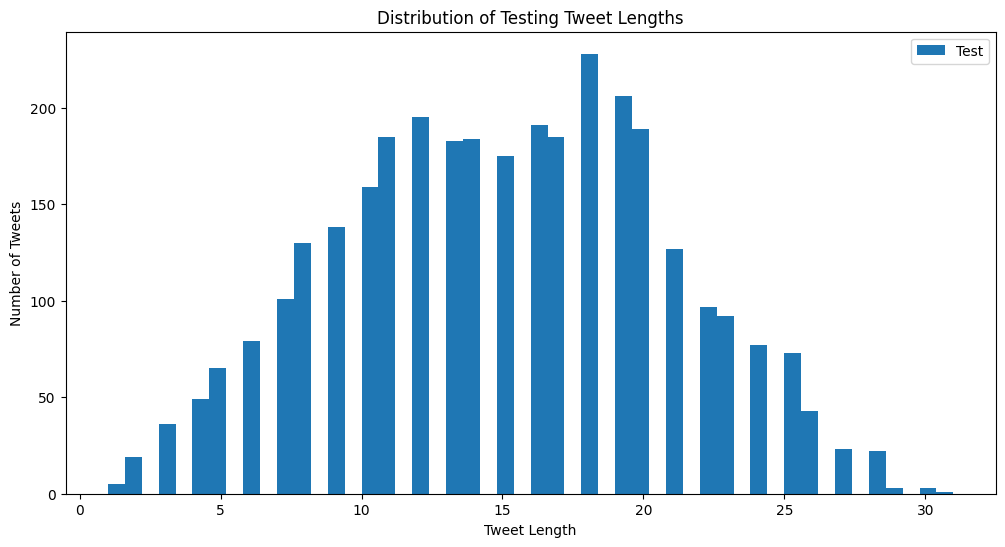

In [16]:
# Distribution of tweet lengths in the testing set
plt.figure(figsize=(12, 6))
plt.hist(test['text_length'], bins=50, label='Test')
plt.xlabel('Tweet Length')
plt.ylabel('Number of Tweets')
plt.title('Distribution of Testing Tweet Lengths')
plt.legend(loc='upper right')
plt.show()

# DATA PROCESSING

All text will be converted to lowercase, and punctuation, emojis, numbers and non-alphanumeric characters will be removed. Tokenization will be implemented converting the text into a sequence if integers with each number representing a specific word. Tweets will have different lengths so padding will be added because a neural network’s inputs must be of the same size. The resulting processed data sets will be NumPy arrays with rows of padded numeric sequences of equal lengths. 


## Tweet Cleaning

In [17]:
# load stop words
stop_words = set(stopwords.words('english'))

# function for cleaning tweets
def tweet_cleaner(text):
    
    # convert to lowercase
    text = text.lower()
    
    # remove stop words
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    # remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # remove non-alphanumeric characters and emojis
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # remove HTML characters
    text = re.sub(r'\d+', '', text)
    
    # remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    return text

In [18]:
# Clean training tweets
train['cleaned_text'] = train['text'].apply(tweet_cleaner)
train_text = train['cleaned_text'].values
target = train['target'].values
# Inspect
print(train.head(5))

   id                                               text  target  text_length  \
0   1  Our Deeds are the Reason of this #earthquake M...       1           13   
1   4             Forest fire near La Ronge Sask. Canada       1            7   
2   5  All residents asked to 'shelter in place' are ...       1           22   
3   6  13,000 people receive #wildfires evacuation or...       1            8   
4   7  Just got sent this photo from Ruby #Alaska as ...       1           16   

                                        cleaned_text  
0       deeds reason earthquake may allah forgive us  
1              forest fire near la ronge sask canada  
2  residents asked shelter place notified officer...  
3   people receive wildfires evacuation orders ca...  
4  got sent photo ruby alaska smoke wildfires pou...  


In [19]:
# Clean testing tweets
test['cleaned_text'] = test['text'].apply(tweet_cleaner)
test_text = test['cleaned_text'].values
# Inspect
print(test.head(5))

   id                                               text  text_length  \
0   0                 Just happened a terrible car crash            6   
1   2  Heard about #earthquake is different cities, s...            9   
2   3  there is a forest fire at spot pond, geese are...           19   
3   9           Apocalypse lighting. #Spokane #wildfires            4   
4  11      Typhoon Soudelor kills 28 in China and Taiwan            8   

                                        cleaned_text  
0                        happened terrible car crash  
1  heard earthquake different cities stay safe ev...  
2  forest fire spot pond geese fleeing across str...  
3              apocalypse lighting spokane wildfires  
4               typhoon soudelor kills  china taiwan  


## Tokenization and Padding

In [20]:
# initialize tokenizer with out-of-vocabulary token.
tokenizer = Tokenizer(num_words = 750, oov_token="<OOV>") 
tokenizer.fit_on_texts(train_text) 

# convert text to sequences of numbers
train_sequences = tokenizer.texts_to_sequences(train_text)
test_sequences = tokenizer.texts_to_sequences(test_text)

# set the maximum length for the sequence padding
max_length = 40 

# pad sequences 
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

# inspect
print('The dimensions of the padded training data are: ',train_padded.shape)
print('The dimensions of the padded testing data are: ',test_padded.shape)

print('The training data after tokenization and padding')
print(train_padded[:2])
print('The testing data after tokenization and padding')
print(test_padded[:2])

The dimensions of the padded training data are:  (7613, 40)
The dimensions of the padded testing data are:  (3263, 40)
The training data after tokenization and padding
[[  1 722 155  55   1   1  12   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [ 96   5 133 542   1   1   1   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]]
The testing data after tokenization and padding
[[  1   1  51  22   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [349 155   1   1 505   1 137   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]]


# MODELS
Now that the tweets are appropriately formatted to be feed into a neural network the models will be constructed. For this problem recurrent neural networks (RNNs) will be used. RNNs are a good choice for this task because they retain information about previous inputs to influence the current input and subsequent output (What Are Recurrent Neural Networks? | IBM, n.d.). Making RNNs well suited for analyzing sequential data and for tasks such as NLP (What Are Recurrent Neural Networks? | IBM, n.d.).

**Reference**

What are Recurrent Neural Networks? | IBM. (n.d.). IBM. https://www.ibm.com/topics/recurrent-neural-networks

## Class to Calculate the F1 Score
F1 scores will be used to evaluate submissions. The F1 score is not built into the Keras library therefore, this class was created to calculate it.  

In [21]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred)
        self.recall.update_state(y_true, y_pred)
    
    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

## Function for Plotting Accuracy, Loss, and F1 score

In [22]:
def model_perfromance_plots(history, model_name):
    """
    Plot the accuracy, loss, and F1 score from the training history.
    
    Inputs: 
    history - the history of the fit method of the model
    model_name - the name of the model
    """

    plt.figure(figsize=(15, 5))

    # Accuracy plot
    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.legend(loc='lower right')

    # Loss plot
    plt.subplot(1, 3, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_name} Loss')
    plt.legend(loc='lower left')

    # F1 Score plot
    plt.subplot(1, 3, 3)
    plt.plot(history.history['f1_score'], label='Train F1 Score')
    plt.plot(history.history['val_f1_score'], label='Validation F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title(f'{model_name} F1 Score')
    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

## Simple RNN Model Architecture
The first layer of the model is an Embedding layer, which helps to reduce the dimensionality of the data by mapping each word to a lower dimensional space. Next a Dropout layer was included to help with overfitting. The Masking layer is included so the model ignores any added padding. Next is the SimpleRNN layer with 8 neurons. The final dense layer includes a sigmoid output function that is appropriate for binary classification.

In [41]:
simple_rnn_model = Sequential([
    Embedding(input_dim=750, output_dim=64), # Set input_dim equal to tokenizer num_words
    Dropout(0.9),  # Dropout to help prevent overfitting
    Masking(mask_value=0),  # Ignore padding
    SimpleRNN(8),  
    Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
])

# compile the model with F1 score
simple_rnn_model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy', F1Score()])

In [24]:
# train the model
hist_simple_rnn = simple_rnn_model.fit(
    train_padded,
    target, 
    epochs=75,
    batch_size=250, 
    validation_split=0.2
)

Epoch 1/75
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.4970 - f1_score: 0.3911 - loss: 0.7032 - val_accuracy: 0.5345 - val_f1_score: 0.0000e+00 - val_loss: 0.6918
Epoch 2/75
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5353 - f1_score: 0.3100 - loss: 0.6918 - val_accuracy: 0.5345 - val_f1_score: 0.0000e+00 - val_loss: 0.6922
Epoch 3/75
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5639 - f1_score: 0.2305 - loss: 0.6867 - val_accuracy: 0.5345 - val_f1_score: 0.0000e+00 - val_loss: 0.6931
Epoch 4/75
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5734 - f1_score: 0.1394 - loss: 0.6833 - val_accuracy: 0.5345 - val_f1_score: 0.0000e+00 - val_loss: 0.6940
Epoch 5/75
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5699 - f1_score: 0.0783 - loss: 0.6861 - val_accuracy: 0.5345 - val_f1_score: 0.0000e+00 - val_loss: 0.6944
Epoch 6/75
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5870 - f1_score: 0.0555 - loss: 0.6775 - val_accuracy: 0.5345 - val_f1

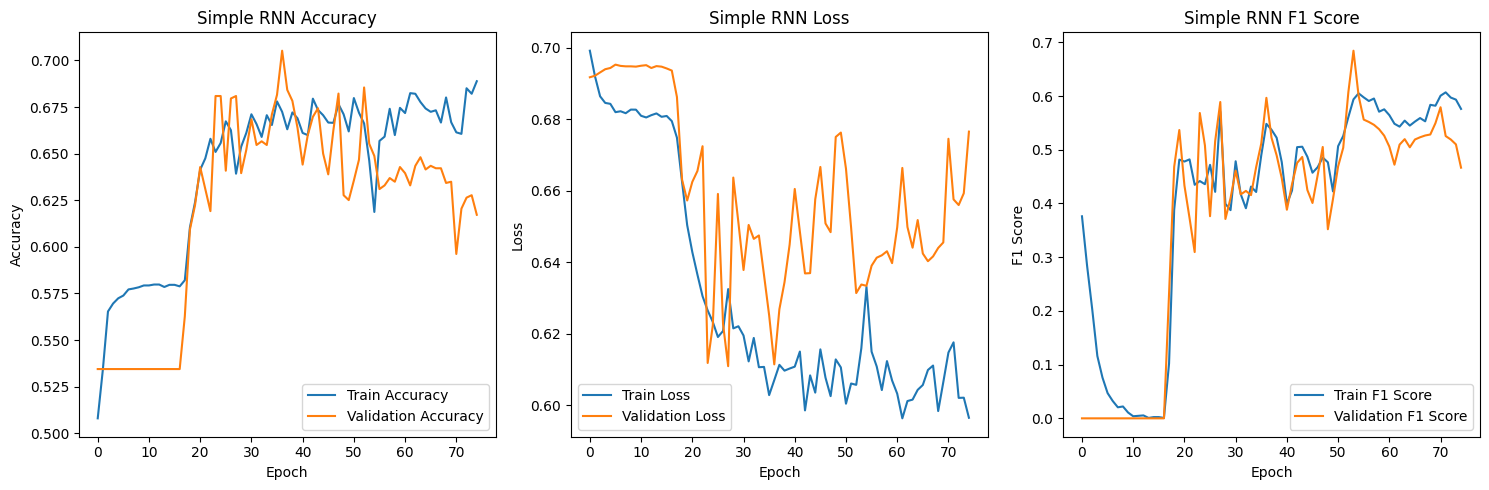

In [25]:
# Plot results
model_perfromance_plots(hist_simple_rnn, "Simple RNN")

## Simple RNN Model Results
Although this model performed well with the training data it can be seen in the performance plots that the model did not handel the validation well. From the loss plot it appears that there is a problem with overfitting. 


## RNN Model Architecture
This model has much of the same architecture as the simple RNN model. One difference is that a second SimpleRNN layer with 4 neurons was added after the first SimpleRNN layer. Also, kernel regularization was added to dense output layer to help the model converge properly. 

In [53]:
rnn_model = Sequential([
    Embedding(input_dim=1000, output_dim=64),
    Dropout(0.9),  # Dropout to help prevent overfitting
    Masking(mask_value=0),  # Ignore padding
    SimpleRNN(8, return_sequences = True),
    SimpleRNN(4),  
    Dense(1, activation='sigmoid', kernel_regularizer=l2(0.1))  # Sigmoid activation for binary classification
])

# compile the model with F1 score
rnn_model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy', F1Score()])

In [54]:
# train the model
hist_rnn = rnn_model.fit(
    train_padded,
    target, 
    epochs=75,
    batch_size=200, 
    validation_split=0.2
)

Epoch 1/75
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.5204 - f1_score: 0.3174 - loss: 0.9891 - val_accuracy: 0.5345 - val_f1_score: 0.0000e+00 - val_loss: 0.9835
Epoch 2/75
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5409 - f1_score: 0.2747 - loss: 0.9558 - val_accuracy: 0.5345 - val_f1_score: 0.0000e+00 - val_loss: 0.9697
Epoch 3/75
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.5659 - f1_score: 0.2236 - loss: 0.9373 - val_accuracy: 0.5345 - val_f1_score: 0.0000e+00 - val_loss: 0.9515
Epoch 4/75
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5509 - f1_score: 0.1699 - loss: 0.9332 - val_accuracy: 0.5345 - val_f1_score: 0.0000e+00 - val_loss: 0.9359
Epoch 5/75
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5600 - f1_score: 0.1841 - loss: 0.9148 - val_accuracy: 0.5345 - val_f1_score: 0.0000e+00 - val_loss: 0.9209
Epoch 6/75
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5672 - f1_score: 0.1675 - loss: 0.9089 - val_accuracy: 0.5351 - val_f1

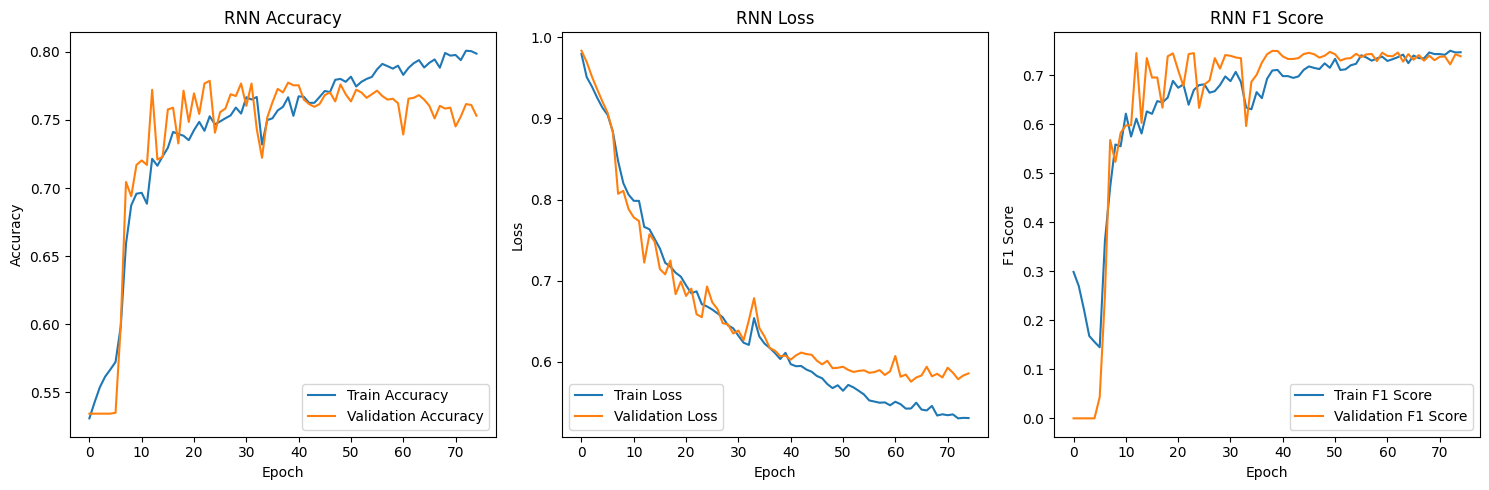

In [55]:
# Plot results
model_perfromance_plots(hist_rnn, "RNN")

## RNN Model Results
This model performed much better than the simple RNN model. Examining the performance plots, it is easy to see that this model is working much better with the validation data than the simple RNN model did. There is much less of a gap in the loss plots of the training and validation data. However, there is still room for improvement. 

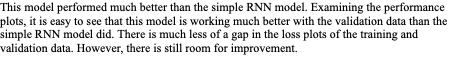
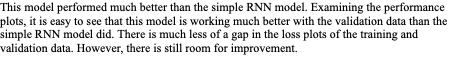
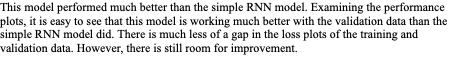
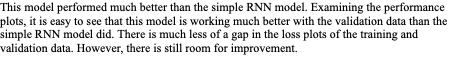

## LSTM Model Architecture
LSTM stands for Long Short-Term Memory and are more complicated than simple RNNs. LSTM models learn long-term dependencies and can remember information from longer sequences but are more computationally taxing. The model here will use the same architecture as the second RNN with LTSM layers in place of the SimpleRNN layers and a second dropout layer was added after the first LSTM layer. 


In [59]:
lstm_model = Sequential([
    Embedding(input_dim = 750, output_dim = 64),
    Dropout(0.9), # dropout to help prevent overfitting
    Masking(mask_value=0),  # Ignore padding
    LSTM(8, return_sequences=True), 
    Dropout(0.9),
    LSTM(4), 
    Dense(1, activation = 'sigmoid', kernel_regularizer=l2(0.2)) # sigmoid activation for binary classification
])
       
# compile the model with F1 score
lstm_model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy', F1Score()])

In [60]:
# train the model
hist_lstm = lstm_model.fit(
    train_padded,
    target, 
    epochs=75,
    batch_size=200, 
    validation_split=0.2
)

Epoch 1/75
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - accuracy: 0.5686 - f1_score: 0.0543 - loss: 0.9028 - val_accuracy: 0.5345 - val_f1_score: 0.0000e+00 - val_loss: 0.9000
Epoch 2/75
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.5744 - f1_score: 0.0059 - loss: 0.8893 - val_accuracy: 0.5345 - val_f1_score: 0.0000e+00 - val_loss: 0.8915
Epoch 3/75
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.5882 - f1_score: 0.0054 - loss: 0.8739 - val_accuracy: 0.5345 - val_f1_score: 0.0000e+00 - val_loss: 0.8825
Epoch 4/75
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.5819 - f1_score: 0.0000e+00 - loss: 0.8652 - val_accuracy: 0.5345 - val_f1_score: 0.0000e+00 - val_loss: 0.8730
Epoch 5/75
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.5678 - f1_score: 0.0000e+00 - loss: 0.8599 - val_accuracy: 0.5345 - val_f1_score: 0.0000e+00 - val_loss: 0.8636
Epoch 6/75
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.5716 - f1_score: 0.0015 - loss: 0.8493 - val_accuracy: 0.5345 

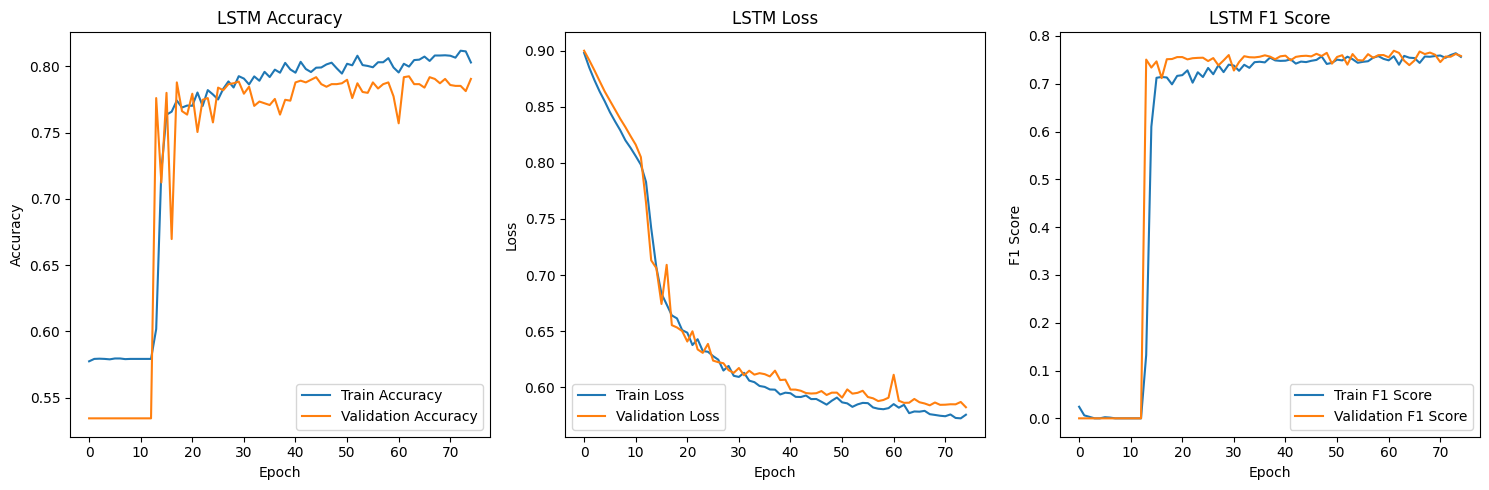

In [61]:
# Plot results
model_perfromance_plots(hist_lstm, "LSTM")

## LSTM Model Results
This model had the best performance and is the model that will be used for the contest submission. From the performance plots this model does not have the problem of overfitting seen in the others. This model also achieved close to 80% accuracy with the validation data. 

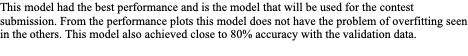
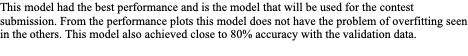
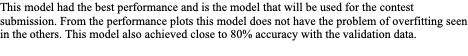
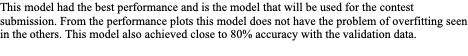

# SUBMISSION

In [62]:
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [64]:
# Make predictions on the test data
test_preds = lstm_model.predict(test_padded)

# Convert predictions to binary labels (0 or 1)
test_preds = (test_preds > 0.5).astype(int)

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


In [65]:
# Prepare the submission 
submission = pd.DataFrame({'id': sample_submission['id'], 'target': test_preds.flatten()})

# Save the submission 
submission.to_csv('submission.csv', index=False)

# Inspect
submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,0
4,11,1


# CONCLUSION

The main challenge with building these networks is that several parameters needed to be optimized for the models to perform well. The dropout layer had a powerful impact. I was surprised that the dropout rate had to be set very high to avoid overfitting. Dropout rates from 10% to 90% were tested with a rate of 90% being the best. Also, the size of the vocabulary impacted model performance. Models were assessed with the size of the vocabulary set between10,000 and 250 words. All models performed better with smaller sized vocabulary between 1,000 and 500 words. The number of neurons in the neuronal layers was impactful, with models having lower number of neurons performing better. Models with 16 or more neurons per layer did not perform well. Adding kernel regularization did help correct overfitting and the learning rate was adjusted with a rate of 0.0005 being optimal.  

One method that could be looked at in the future to improve model performance is synonym replacement. This is a data augmentation technique which randomly chooses words and replaces them with a randomly chosen synonym (Monitsky, 2023). Another augmentation technique that could be used to enhance model performance is back translation. This is where some text is translated into a different language then back to its original language (Monitsky, 2023). Both techniques have been shown to work well with NLP tasks. 

**Reference**

Monitsky, V. (2023, November 7). Data augmentation for natural language Processing - Vince Monitsky - Medium. Medium. https://medium.com/@vmn11/data-augmentation-for-natural-language-processing-e718f53e387f

